# Description

You are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column. The task is to predict the value of target column in the test set. To download the dataset make sure you have kaggle api installed on your machine.

    kaggle competitions download -c santander-customer-transaction-prediction


In [1]:
import pandas as pd
import numpy as np

## Read train data

In [2]:
train = pd.read_csv('./data/train.csv.zip',
                    compression='zip',
                    header=0,
                    sep=',',
                    quotechar='"')

In [3]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
m,n = train.shape
print("shape of train dataframe {}, {}".format(m,n))

shape of train dataframe 200000, 202


In [5]:
train.dropna().shape

(200000, 202)

# Distribution of target classes

In [6]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

# Describe 

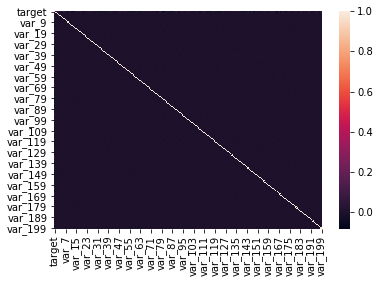

In [8]:
import seaborn as sns
sns.heatmap(train.corr())

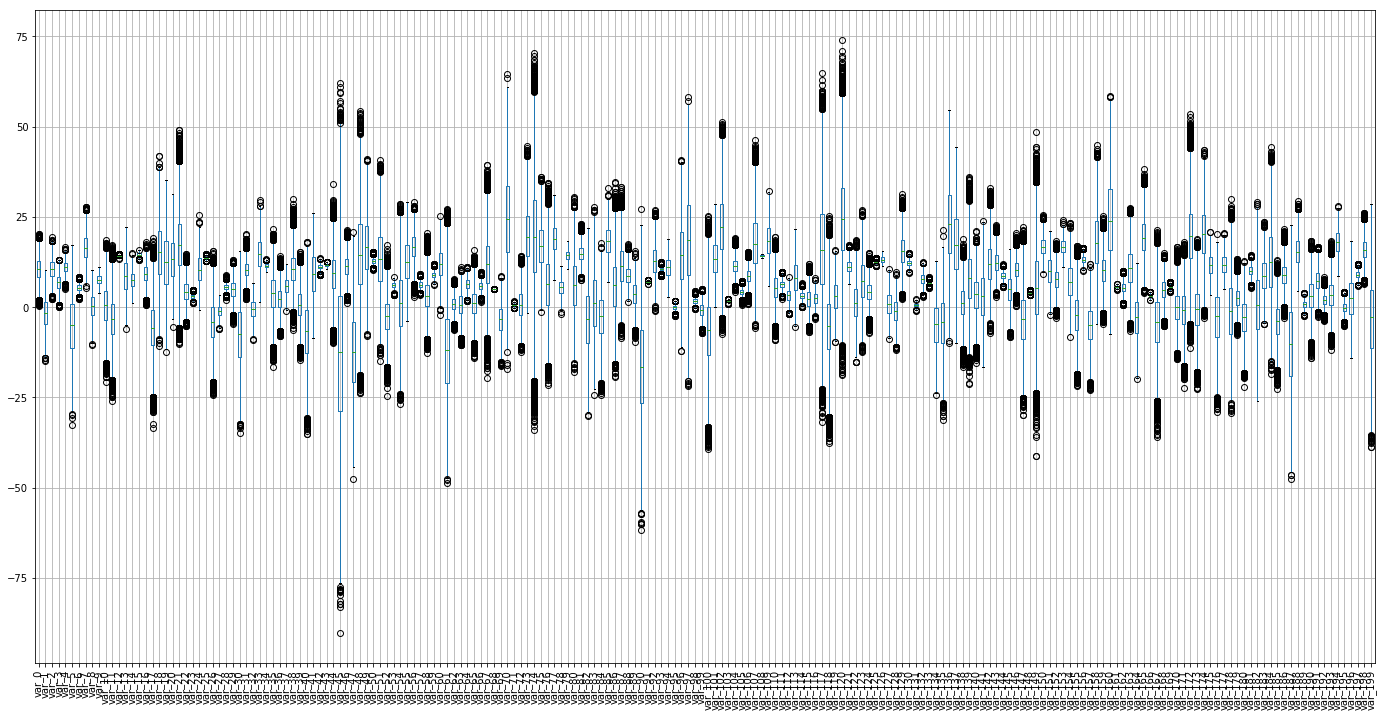

In [9]:
train.loc[:, train.dtypes == np.float64].boxplot(figsize=(24,12), rot = 90)

In [10]:
# Identify feature columns
columns_to_select = [cols for cols in train.columns.values.tolist() if cols not in ['ID_code','target']]

In [11]:
%%time
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train[columns_to_select] = scaler.fit_transform(train[columns_to_select])

CPU times: user 6.17 s, sys: 1.5 s, total: 7.68 s
Wall time: 4.4 s


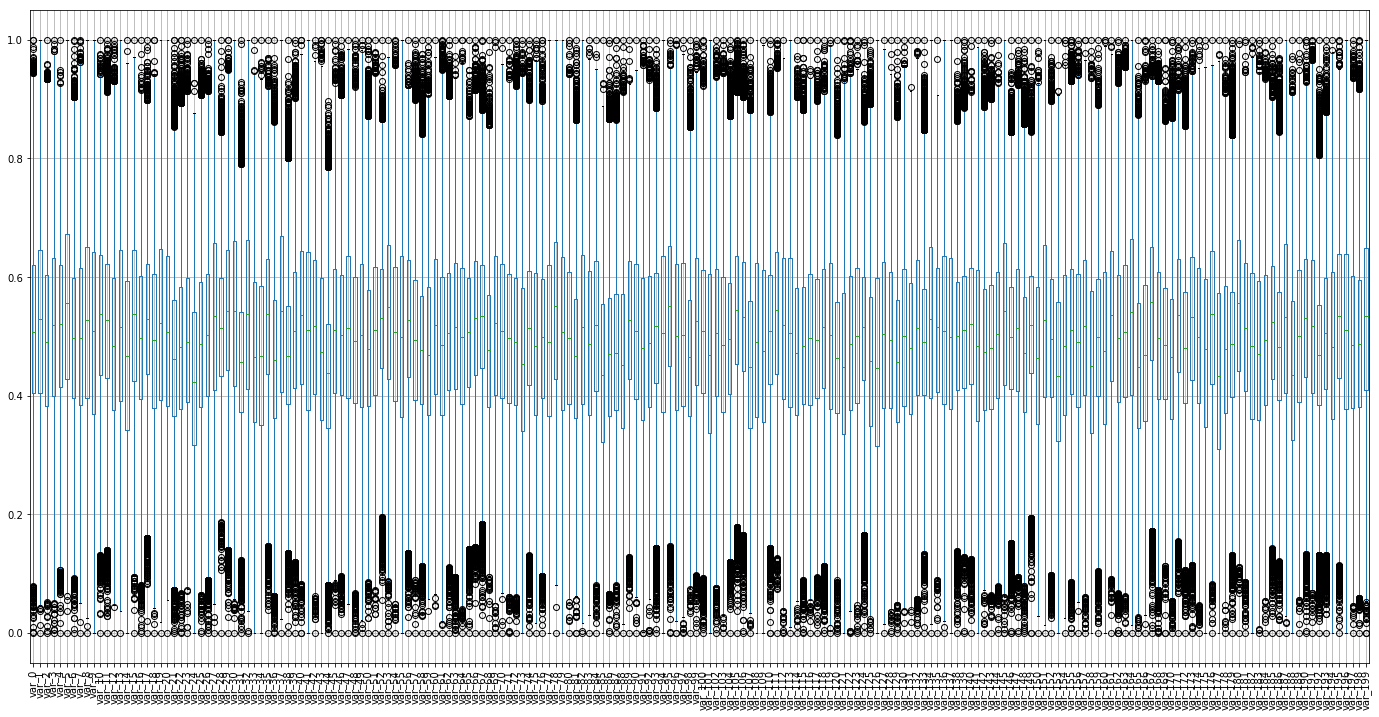

In [12]:
train.loc[:, train.dtypes == np.float64] \
                            .boxplot(figsize=(24,12), rot = 90)

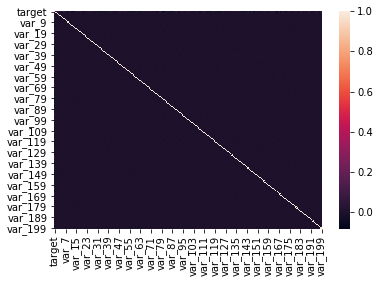

In [13]:
sns.heatmap(train.corr())

# Split to train and test data

In [11]:
from sklearn.model_selection import train_test_split

xs = train[columns_to_select]
ys = train['target']

x_train, x_test, y_train, y_test = train_test_split(xs, ys,
                                                    test_size=0.30,
                                                    random_state=0,
                                                    stratify=ys)

# Smote analysis

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
%%time
smt = SMOTE()
X_train, Y_train = smt.fit_sample(x_train, y_train,)

CPU times: user 1min 14s, sys: 457 ms, total: 1min 15s
Wall time: 1min 13s


In [14]:
np.bincount(Y_train)

array([125931, 125931])

## Model fitting

In [15]:
from sklearn.ensemble import RandomForestClassifier
import pickle

In [ ]:
%%time
clf = RandomForestClassifier(n_estimators=500,
                             max_depth =10,
                             random_state=0,
                             n_jobs=-1)

clf.fit(X_train,Y_train)

## Saving the model

In [ ]:
with open('./model/rf_model_normalized_columns.pkl','wb') as f:
    pickle.dump(clf, f) 

## Loading the model

In [ ]:
with open('./model/rf_model_normalized_columns.pkl','rb') as f:
    clf = pickle.load(f)


In [22]:
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, recall_score, roc_auc_score


In [ ]:
y_pred = clf.predict(x_test)
print("accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("precision score: {}".format(average_precision_score(y_pred,y_test)))

In [ ]:
confusion_matrix(y_test, y_pred)

---
# Using XGBoost

In [16]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


In [17]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [18]:
df_=pd.DataFrame(X_train,columns=columns_to_select)
df_['label']= Y_train

In [19]:
%%time
xgb.fit(df_[columns_to_select],df_['label'],eval_metric='auc')

CPU times: user 1h 11min 44s, sys: 983 ms, total: 1h 11min 45s
Wall time: 17min 56s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [20]:
with open('./model/xgb_model.pkl','wb') as f:
    pickle.dump(xgb, f) 

In [ ]:
with open('./model/xgb_model.pkl','rb') as f:
    xgb = pickle.load(f)

In [23]:
testdf_ = pd.DataFrame(x_test,columns=columns_to_select)
testdf_['label'] = y_test
testdf_['prediction']= xgb.predict(testdf_[columns_to_select])
testdf_['probability'] = xgb.predict_proba(testdf_[columns_to_select])[:,1]

In [24]:
print("accuracy: {}".format(accuracy_score(testdf_['label'], testdf_['prediction'])))
print("precision score: {}".format(average_precision_score(testdf_['prediction'],testdf_['label'])))
print("roc auc score: {}".format(roc_auc_score(testdf_['label'],testdf_['probability'])))


accuracy: 0.87565
precision score: 0.18638845036224352
roc auc score: 0.7780051577861095


In [25]:
confusion_matrix(testdf_['label'], testdf_['prediction'])

array([[50464,  3507],
       [ 3954,  2075]])

Confusion matrix for `XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)` without being normalized

        array([[50516,  3455],
           [ 3941,  2088]])